In [232]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
import tensorflow as tf
import zipfile

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib inline

In [2]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data'),
    data = 'sverepec_24.zip',
    # data = 'hysped_integrovane_redukovane.zip',
    # data = 'Sverepec_spolu.zip',
)
display(JSON(cfg))

<IPython.core.display.JSON object>

In [3]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

# Analyze data

In [4]:
filename = os.path.join(cfg['data_dir'], cfg['data'])
df = pd.read_csv(filename)

display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<hr>'))
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())

Geometry           X            Y  pointid  grid_code  b1_12_10_2  \
0       Point -467357.396 -1185629.188  7265593   0.001564    0.001564   
1       Point -467357.396 -1185629.398  7269027   0.001841    0.001841   
2       Point -467357.186 -1185629.398  7269028   0.002177    0.002177   
3       Point -467357.396 -1185629.608  7272461   0.002373    0.002373   
4       Point -467357.186 -1185629.608  7272462   0.002644    0.002644   
...       ...         ...          ...      ...        ...         ...   
6219    Point -467365.376 -1185662.998  7818429   0.001723    0.001723   
6220    Point -467365.166 -1185662.998  7818430   0.002050    0.002050   
6221    Point -467364.956 -1185662.998  7818431   0.002680    0.002680   
6222    Point -467365.166 -1185663.208  7821864   0.003241    0.003241   
6223    Point -467364.956 -1185663.208  7821865   0.002807    0.002807   

      b2_12_10_2  b3_12_10_2  b4_12_10_2  b5_12_10_2  ...  b473_12_10  \
0       0.001741    0.001547    0.001737    0.001705  ...       -9999   
1       0.002274    0.002202    0.002274    0.002430  ...       -9999   
2       0.002608    0.002603    0.002664    0.002728  ...       -9999   
3       0.002544    0.002530    0.002706    0.002820  ...       -9999   
4       0.003305    0.003202    0.003318    0.003066  ...       -9999   
...          ...         ...         ...         ...  ...         ...   
6219    0.001717    0.001806    0.001756    0.002016  ...       -9999   
6220    0.002478    0.002440    0.002405    0.002773  ...       -9999   
6221    0.002790    0.003123    0.003634    0.003442  ...       -9999   
6222    0.003114    0.003430    0.003580    0.003798  ...       -9999   
6223    0.003085    0.003269    0.003569    0.003891  ...       -9999   

      b474_12_10  IDFULL       DATUM     POINT_X      POINT_Y  DRUH_DR  IDPL  \
0          -9999   24-35  12_10_2022 -467357.396 -1185629.188       SM    24   
1          -9999   24-35  12_10_2022 -467357.396 -1185629.398       SM    24   
2          -9999   24-35  12_10_2022 -467357.186 -1185629.398       SM    24   
3          -9999   24-35  12_10_2022 -467357.396 -1185629.608       SM    24   
4          -9999   24-35  12_10_2022 -467357.186 -1185629.608       SM    24   
...          ...     ...         ...         ...          ...      ...   ...   
6219       -9999    24-1  12_10_2022 -467365.376 -1185662.998       OS    24   
6220       -9999    24-1  12_10_2022 -467365.166 -1185662.998       OS    24   
6221       -9999    24-1  12_10_2022 -467364.956 -1185662.998       OS    24   
6222       -9999    24-1  12_10_2022 -467365.166 -1185663.208       OS    24   
6223       -9999    24-1  12_10_2022 -467364.956 -1185663.208       OS    24   

        NAZ_PL   POSKODENIE  
0     sverepec  neposkodeny  
1     sverepec  neposkodeny  
2     sverepec  neposkodeny  
3     sverepec  neposkodeny  
4     sverepec  neposkodeny  
...        ...          ...  
6219  sverepec  neposkodeny  
6220  sverepec  neposkodeny  
6221  sverepec  neposkodeny  
6222  sverepec  neposkodeny  
6223  sverepec  neposkodeny  

[6224 rows x 487 columns]

X             Y       pointid    grid_code   b1_12_10_2  \
count    6224.000000  6.224000e+03  6.224000e+03  6224.000000  6224.000000   
mean  -467363.575918 -1.185647e+06  7.553752e+06     0.002145     0.002145   
std         6.358555  8.691287e+00  1.421202e+05     0.000812     0.000812   
min   -467380.706000 -1.185663e+06  7.265593e+06     0.000721     0.000721   
25%   -467368.316000 -1.185654e+06  7.444158e+06     0.001482     0.001482   
50%   -467363.906000 -1.185647e+06  7.557496e+06     0.001985     0.001985   
75%   -467358.866000 -1.185640e+06  7.663914e+06     0.002683     0.002683   
max   -467346.266000 -1.185629e+06  7.821865e+06     0.005156     0.005156   

        b2_12_10_2   b3_12_10_2   b4_12_10_2   b5_12_10_2   b6_12_10_2  ...  \
count  6224.000000  6224.000000  6224.000000  6224.000000  6224.000000  ...   
mean      0.002184     0.002293     0.002411     0.002445     0.002504  ...   
std       0.000852     0.000912     0.000977     0.001003     0.001042  ...   
min       0.000543     0.000620     0.000792     0.000671     0.000745  ...   
25%       0.001474     0.001534     0.001591     0.001593     0.001609  ...   
50%       0.002022     0.002128     0.002232     0.002257     0.002327  ...   
75%       0.002756     0.002913     0.003065     0.003143     0.003229  ...   
max       0.005470     0.006551     0.006178     0.006284     0.006356  ...   

       b468_12_10  b469_12_10  b470_12_10  b471_12_10  b472_12_10  b473_12_10  \
count      6224.0      6224.0      6224.0      6224.0      6224.0      6224.0   
mean      -9999.0     -9999.0     -9999.0     -9999.0     -9999.0     -9999.0   
std           0.0         0.0         0.0         0.0         0.0         0.0   
min       -9999.0     -9999.0     -9999.0     -9999.0     -9999.0     -9999.0   
25%       -9999.0     -9999.0     -9999.0     -9999.0     -9999.0     -9999.0   
50%       -9999.0     -9999.0     -9999.0     -9999.0     -9999.0     -9999.0   
75%       -9999.0     -9999.0     -9999.0     -9999.0     -9999.0     -9999.0   
max       -9999.0     -9999.0     -9999.0     -9999.0     -9999.0     -9999.0   

       b474_12_10        POINT_X       POINT_Y    IDPL  
count      6224.0    6224.000000  6.224000e+03  6224.0  
mean      -9999.0 -467363.575918 -1.185647e+06    24.0  
std           0.0       6.358555  8.691287e+00     0.0  
min       -9999.0 -467380.706000 -1.185663e+06    24.0  
25%       -9999.0 -467368.316000 -1.185654e+06    24.0  
50%       -9999.0 -467363.906000 -1.185647e+06    24.0  
75%       -9999.0 -467358.866000 -1.185640e+06    24.0  
max       -9999.0 -467346.266000 -1.185629e+06    24.0  

[8 rows x 481 columns]

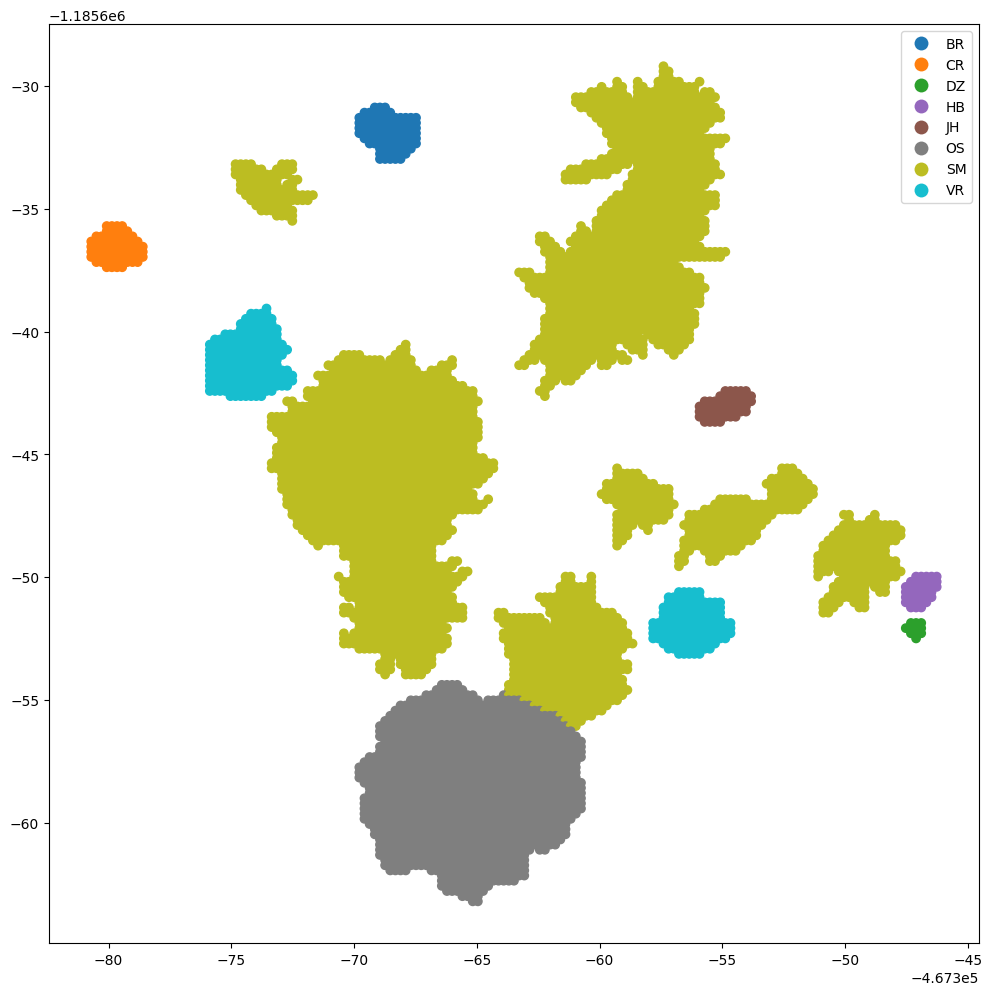

In [5]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y)
)
gdf.crs = cfg['crs']

gdf.plot(column=gdf.DRUH_DR.name, legend=True, figsize=cfg['figsize'])
plt.show()

In [6]:
gdf_sk_obce = gpd.read_file(os.path.join('..', 'maps', 'ah_shp_3.zip'), layer='obec_3')
gdf_sk_obce = gdf_sk_obce.to_crs(cfg['crs'])

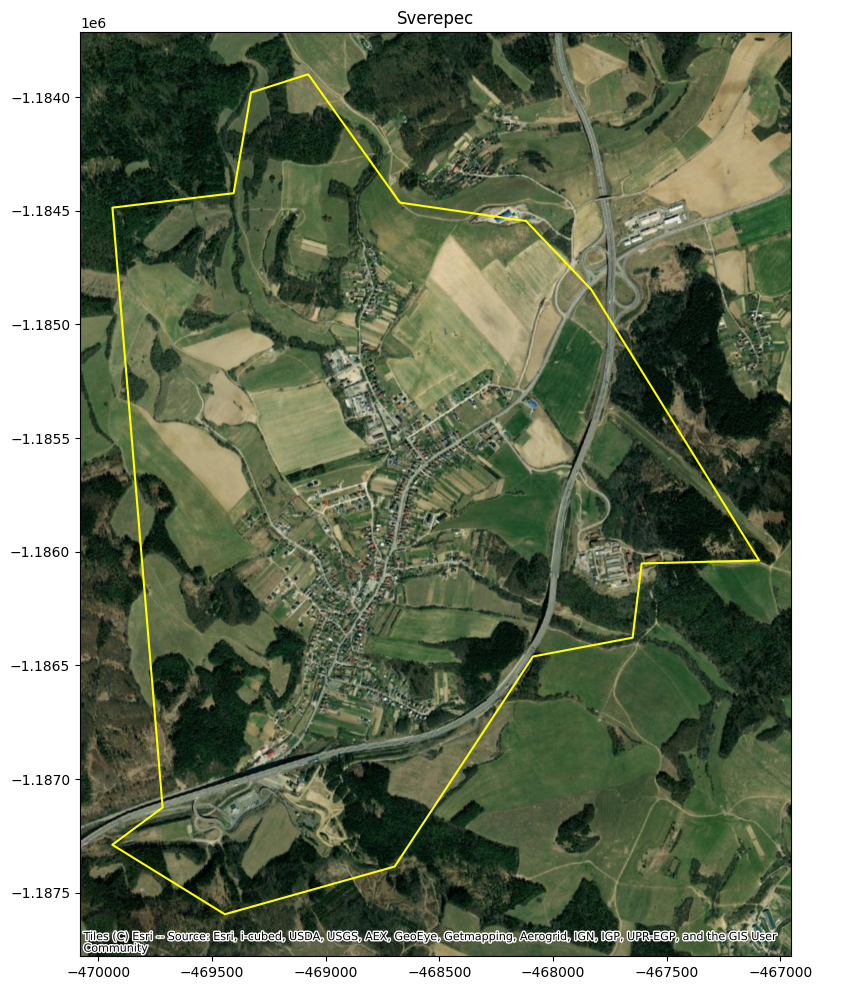

In [7]:
gdf_sverepec = gdf_sk_obce[gdf_sk_obce.NM4 == 'Sverepec']
ax = gdf_sverepec.boundary.plot(figsize=cfg['figsize'], color=to_rgba('yellow', 1.0))
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=cfg['crs'])
plt.title(gdf_sverepec.NM4.values[0])
plt.show()

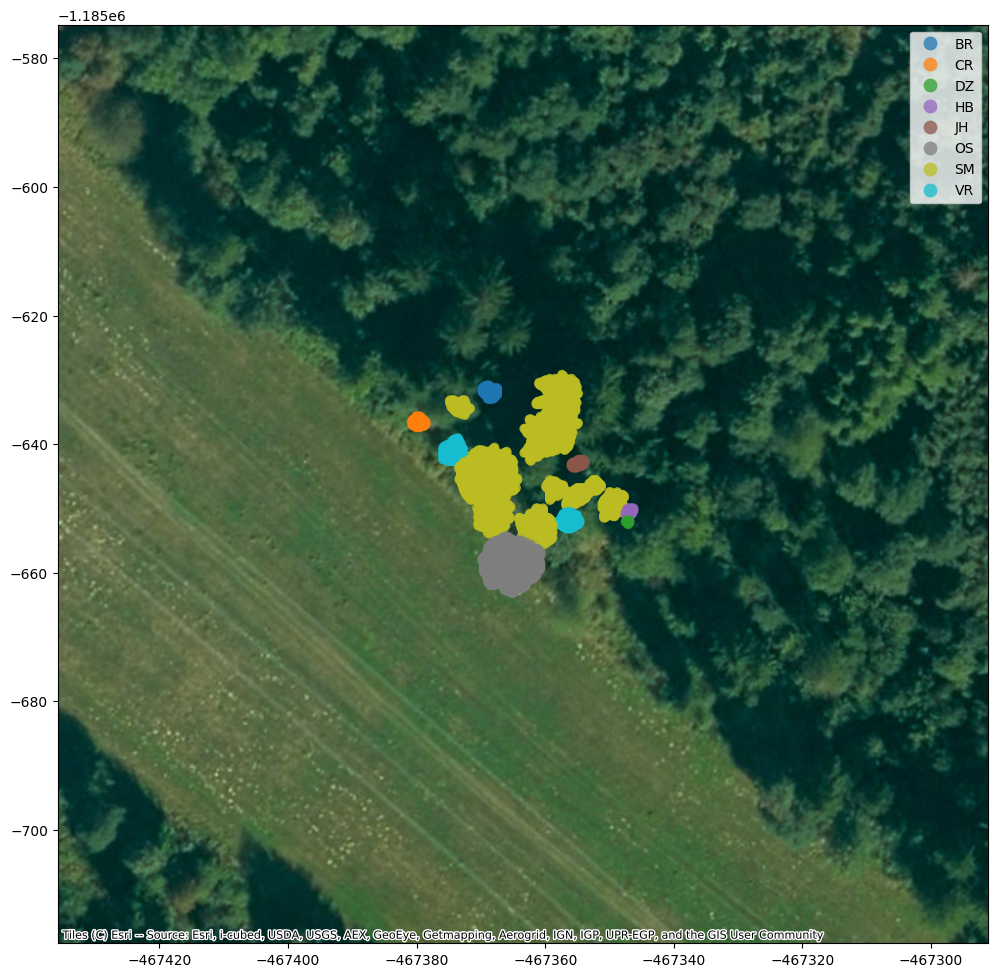

In [8]:
# select data to plot
gdf_plot = gdf[['geometry','DRUH_DR']]

# zoom out
scale = 1.6
bbox = gdf.total_bounds
dx = scale * np.abs(bbox[2]-bbox[0])
dy = scale * np.abs(bbox[3]-bbox[1])

# plot
f, ax = plt.subplots(1, figsize=cfg['figsize'])

# set boundaries
ax.set_xlim(bbox[0]-dx, bbox[2]+dx)
ax.set_ylim(bbox[1]-dy, bbox[3]+dy)

gdf_plot.plot(
    ax=ax,
    column='DRUH_DR',
    legend=True,
    alpha=0.75,
)

# basemap - satelite imagery
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=cfg['crs'])

plt.show()

In [9]:
print('columns (%d): %s' % (df.columns.shape[0], ', '.join(df.columns)))

columns (488): Geometry, X, Y, pointid, grid_code, b1_12_10_2, b2_12_10_2, b3_12_10_2, b4_12_10_2, b5_12_10_2, b6_12_10_2, b7_12_10_2, b8_12_10_2, b9_12_10_2, b10_12_10_, b11_12_10_, b12_12_10_, b13_12_10_, b14_12_10_, b15_12_10_, b16_12_10_, b17_12_10_, b18_12_10_, b19_12_10_, b20_12_10_, b21_12_10_, b22_12_10_, b23_12_10_, b24_12_10_, b25_12_10_, b26_12_10_, b27_12_10_, b28_12_10_, b29_12_10_, b30_12_10_, b31_12_10_, b32_12_10_, b33_12_10_, b34_12_10_, b35_12_10_, b36_12_10_, b37_12_10_, b38_12_10_, b39_12_10_, b40_12_10_, b41_12_10_, b42_12_10_, b43_12_10_, b44_12_10_, b45_12_10_, b46_12_10_, b47_12_10_, b48_12_10_, b49_12_10_, b50_12_10_, b51_12_10_, b52_12_10_, b53_12_10_, b54_12_10_, b55_12_10_, b56_12_10_, b57_12_10_, b58_12_10_, b59_12_10_, b60_12_10_, b61_12_10_, b62_12_10_, b63_12_10_, b64_12_10_, b65_12_10_, b66_12_10_, b67_12_10_, b68_12_10_, b69_12_10_, b70_12_10_, b71_12_10_, b72_12_10_, b73_12_10_, b74_12_10_, b75_12_10_, b76_12_10_, b77_12_10_, b78_12_10_, b79_12_10_, b

## rasterize data

total_points: 6224
(x_points, y_points): (80, 79)


<xarray.Dataset>
Dimensions:      (y: 80, x: 81)
Coordinates:
  * y            (y) float64 -1.186e+06 -1.186e+06 ... -1.186e+06 -1.186e+06
  * x            (x) float64 -4.674e+05 -4.674e+05 ... -4.673e+05 -4.673e+05
    spatial_ref  int64 0
Data variables: (12/482)
    X            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Y            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    pointid      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    grid_code    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b1_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b2_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    b473_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b474_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    POINT_X      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    POINT_Y      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    IDPL         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    DRUH_DR_ENC  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

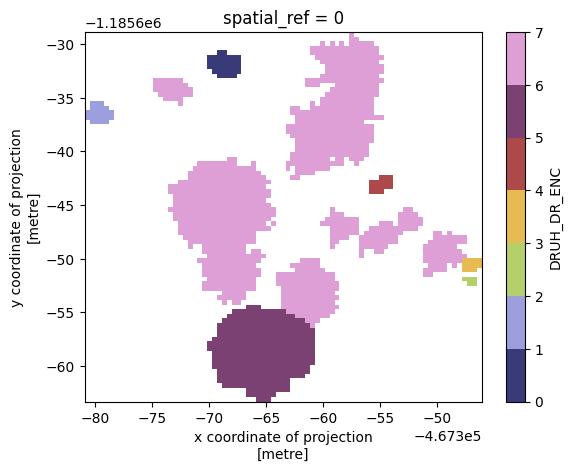

In [345]:
label_encoder = LabelEncoder()
gdf['DRUH_DR_ENC'] = label_encoder.fit_transform(gdf['DRUH_DR'])

total_points = gdf.shape[0]

bbox = gdf.total_bounds
dx = np.abs(bbox[2]-bbox[0])
dy = np.abs(bbox[3]-bbox[1])
ratio = dx/dy

# dx/dy = x_points/y_points -->
# y_points * dx = x_points * dy -->
# x_points * y_points * dx = x_points^2 * dy -->
# total_points * dx = x_points^2 * dy -->
# total_points * dx/dy = x_points^2 -->
# sqrt(total_points * ratio) = x_points

x_points = np.sqrt(total_points * ratio)
y_points = int(np.ceil(total_points / x_points))
x_points = int(np.ceil(x_points))

print('total_points: %d' % total_points)
print('(x_points, y_points): %s' % str((x_points, y_points)))

geo_grid = make_geocube(
    vector_data=gdf,
    # measureme>nts=['DRUH_DR_ENC'],
    output_crs=cfg['crs'],
    resolution=(-(dy/y_points), dx/x_points),
    interpolate_na_method=None,
    rasterize_function=geocube.rasterize.rasterize_image,
)

display(geo_grid)

# mask nodata and plot
# geo_grid.DRUH_DR_ENC.where(geo_grid.DRUH_DR_ENC != np.NaN).plot(cmap='tab20b')
geo_grid.DRUH_DR_ENC.plot(cmap='tab20b', levels=len(label_encoder.classes_))
plt.show()

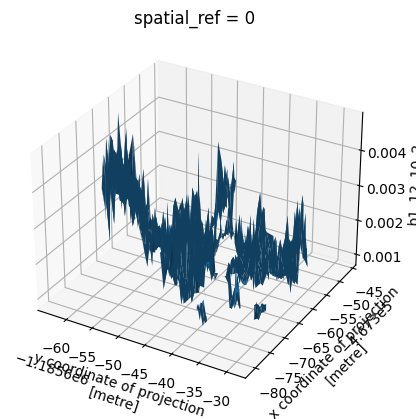

In [348]:
geo_grid.b1_12_10_2.T.plot.surface()
plt.show()

In [378]:
r = geo_grid.rolling(x=3, y=3, center=True, min_periods=1)

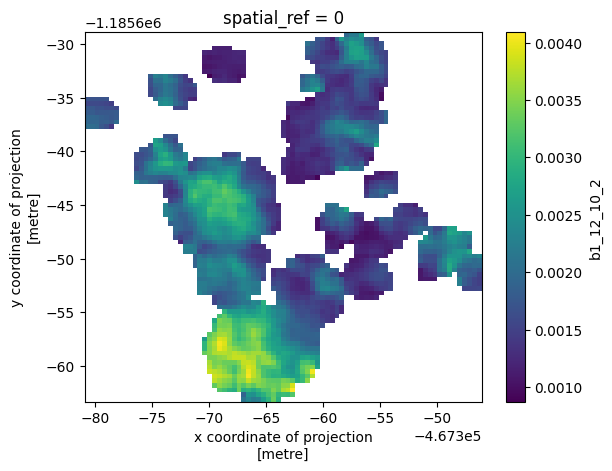

In [379]:
r.mean().b1_12_10_2.plot()
plt.show()

In [412]:
i = 0

def myfn(x, axis=0):
    global i
    i+=1
    return x

r.reduce(np.std)


<xarray.Dataset>
Dimensions:      (y: 80, x: 81)
Coordinates:
  * y            (y) float64 -1.186e+06 -1.186e+06 ... -1.186e+06 -1.186e+06
  * x            (x) float64 -4.674e+05 -4.674e+05 ... -4.673e+05 -4.673e+05
    spatial_ref  int64 0
Data variables: (12/482)
    X            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Y            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    pointid      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    grid_code    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b1_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b2_12_10_2   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    b473_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    b474_12_10   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    POINT_X      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    POINT_Y      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    IDPL         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    DRUH_DR_ENC  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [430]:
geo_grid.data_vars['b1_12_10_2'][10,14]

<xarray.DataArray 'b1_12_10_2' ()>
array(0.002)
Coordinates:
    y            float64 -1.186e+06
    x            float64 -4.674e+05
    spatial_ref  int64 0
Attributes:
    name:        b1_12_10_2
    long_name:   b1_12_10_2
    _FillValue:  nan

In [439]:
r = geo_grid.data_vars['b1_12_10_2'].rolling(x=3, y=3)
r = r.construct(x="x_win", y="y_win", stride=1)
r[10][14]

<xarray.DataArray 'b1_12_10_2' (x_win: 3, y_win: 3)>
array([[  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan, 0.002]])
Coordinates:
    y            float64 -1.186e+06
    x            float64 -4.674e+05
    spatial_ref  int64 0
Dimensions without coordinates: x_win, y_win
Attributes:
    name:        b1_12_10_2
    long_name:   b1_12_10_2
    _FillValue:  nan

In [448]:
r = geo_grid.rolling(x=3, y=3)
r = r.construct(x="x_win", y="y_win", stride=1)
x = 18
y = 11
display(r.b1_12_10_2[y][x])
display(r.DRUH_DR_ENC[y][x])

<xarray.DataArray 'b1_12_10_2' (x_win: 3, y_win: 3)>
array([[  nan, 0.002, 0.002],
       [  nan, 0.002, 0.003],
       [  nan, 0.002, 0.002]])
Coordinates:
    y            float64 -1.186e+06
    x            float64 -4.674e+05
    spatial_ref  int64 0
Dimensions without coordinates: x_win, y_win
Attributes:
    name:        b1_12_10_2
    long_name:   b1_12_10_2
    _FillValue:  nan

<xarray.DataArray 'DRUH_DR_ENC' (x_win: 3, y_win: 3)>
array([[nan,  6.,  6.],
       [nan,  6.,  6.],
       [nan,  6.,  6.]])
Coordinates:
    y            float64 -1.186e+06
    x            float64 -4.674e+05
    spatial_ref  int64 0
Dimensions without coordinates: x_win, y_win
Attributes:
    name:        DRUH_DR_ENC
    long_name:   DRUH_DR_ENC
    _FillValue:  nan

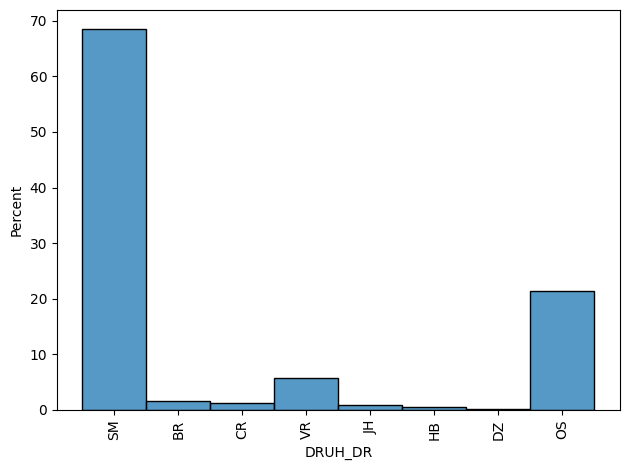

In [272]:
g = sns.histplot(df[df.DRUH_DR.name], stat='percent')
g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

## Plot a selected feature

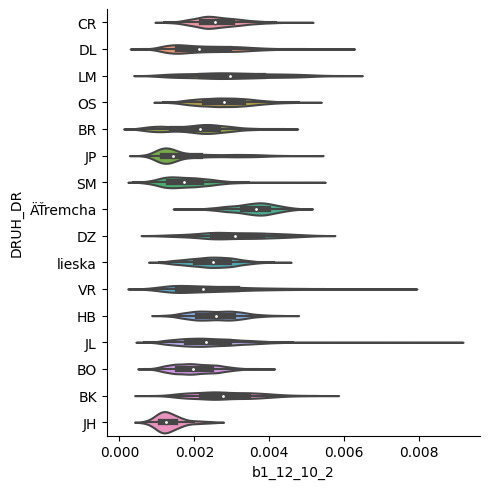

In [38]:
sns.catplot(data=df, x='b1_12_10_2', y='DRUH_DR', kind='violin')
plt.show()

## Plot densities of the first 20 hyperspectral features per each class

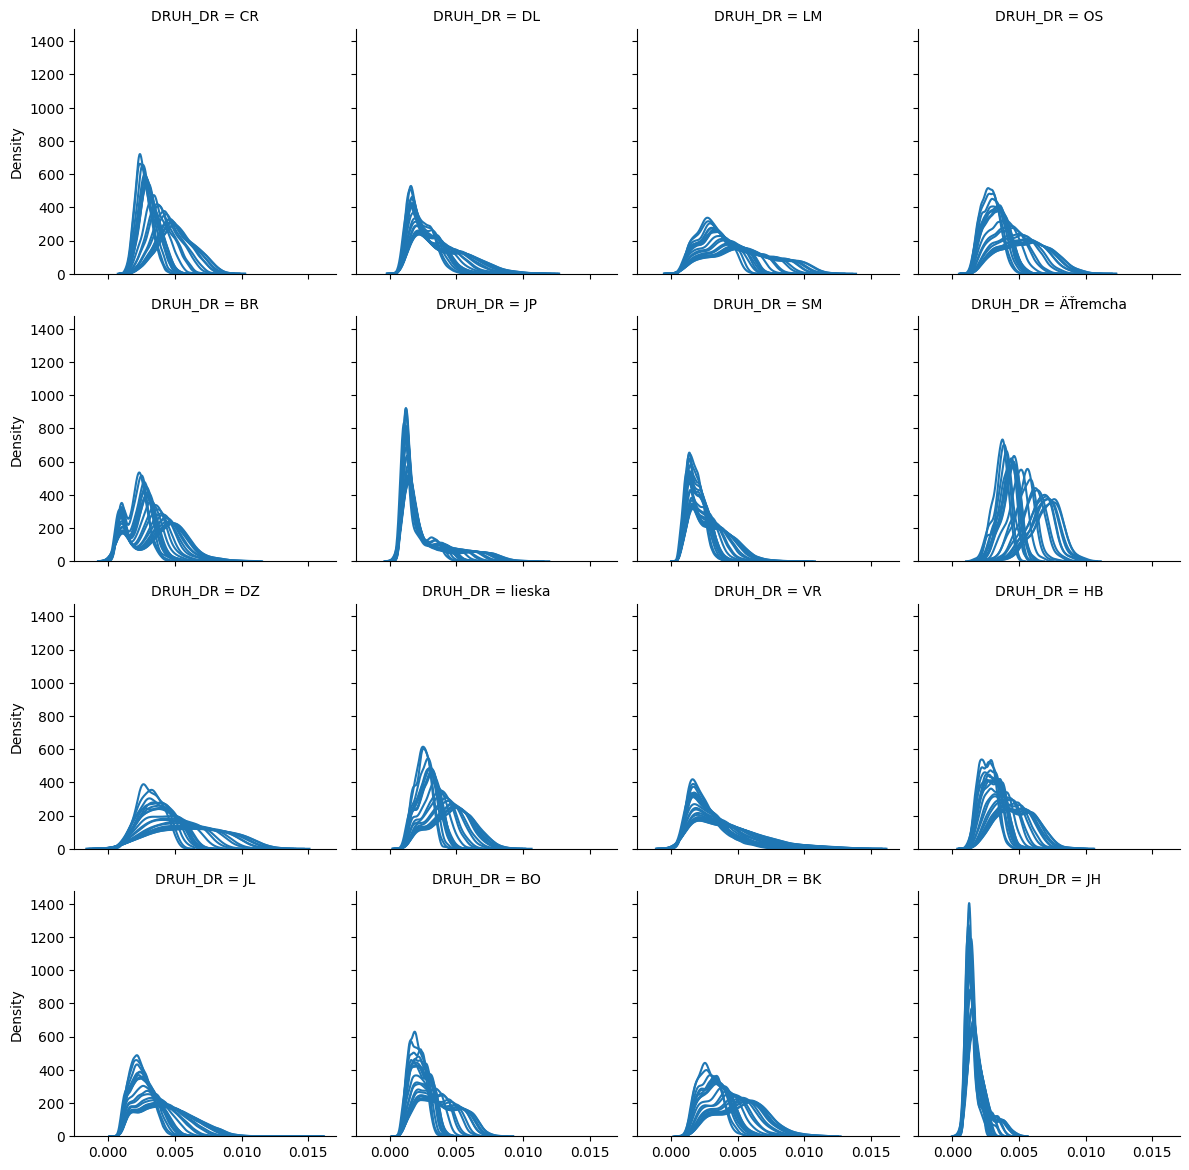

In [75]:
g = sns.FacetGrid(df, col="DRUH_DR", col_wrap=4)

# plot only features starting with 'b0, b1, ..., b9'
for col in enumerate(df.columns[df.columns.to_series().str.match(r'^b\d+.*')]):
    if col[0] < 20:
        gg = g.map(sns.kdeplot, col[1], label=col[1], warn_singular=False)
        gg.set_axis_labels(x_var='')

# g.add_legend()
plt.show()

## Sampling data

In [77]:
df_sample = df.sample(frac=0.1)

In [78]:
df_sample[df_sample.columns[df_sample.columns.to_series().str.match(r'^b\d+.*|DRUH_DR')]]

b1_12_10_2  b2_12_10_2  b3_12_10_2  b4_12_10_2  b5_12_10_2  b6_12_10_2  \
71265    0.001690    0.002245    0.001937    0.002447    0.002050    0.002198   
82611    0.001279    0.001137    0.000992    0.000950    0.001083    0.001172   
24069    0.001044    0.001114    0.001205    0.001542    0.001447    0.001180   
32334    0.002567    0.002937    0.002937    0.002937    0.003223    0.003263   
11112    0.002472    0.002107    0.002280    0.002415    0.002626    0.002638   
...           ...         ...         ...         ...         ...         ...   
33373    0.003634    0.003962    0.003965    0.004139    0.003748    0.004272   
31963    0.001408    0.001400    0.001539    0.001489    0.001505    0.001612   
83385    0.002794    0.002642    0.002563    0.002987    0.003093    0.003077   
64630    0.001411    0.001380    0.001579    0.001381    0.001392    0.001494   
4981     0.003354    0.003564    0.003955    0.003992    0.004124    0.004303   

       b7_12_10_2  b8_12_10_2  b9_12_10_2  b10_12_10_  ...  b466_12_10  \
71265    0.002100    0.002010    0.001936    0.002256  ...           0   
82611    0.000970    0.001191    0.000990    0.001065  ...           0   
24069    0.001264    0.001183    0.001163    0.001400  ...       -9999   
32334    0.003376    0.003001    0.003096    0.003688  ...       -9999   
11112    0.002720    0.002514    0.002351    0.002931  ...       -9999   
...           ...         ...         ...         ...  ...         ...   
33373    0.004619    0.004480    0.004299    0.004677  ...       -9999   
31963    0.001342    0.001505    0.001499    0.001626  ...       -9999   
83385    0.003061    0.003018    0.002747    0.003263  ...       -9999   
64630    0.001500    0.001405    0.001219    0.001423  ...           0   
4981     0.004265    0.004326    0.004411    0.005034  ...       -9999   

       b467_12_10  b468_12_10  b469_12_10  b470_12_10  b471_12_10  b472_12_10  \
71265           0           0           0           0           0           0   
82611           0           0           0           0           0           0   
24069       -9999       -9999       -9999       -9999       -9999       -9999   
32334       -9999       -9999       -9999       -9999       -9999       -9999   
11112       -9999       -9999       -9999       -9999       -9999       -9999   
...           ...         ...         ...         ...         ...         ...   
33373       -9999       -9999       -9999       -9999       -9999       -9999   
31963       -9999       -9999       -9999       -9999       -9999       -9999   
83385       -9999       -9999       -9999       -9999       -9999       -9999   
64630           0           0           0           0           0           0   
4981        -9999       -9999       -9999       -9999       -9999       -9999   

       b473_12_10  b474_12_10  DRUH_DR  
71265           0           0       JL  
82611           0           0       SM  
24069       -9999       -9999       SM  
32334       -9999       -9999       JL  
11112       -9999       -9999       SM  
...           ...         ...      ...  
33373       -9999       -9999       JL  
31963       -9999       -9999       DL  
83385       -9999       -9999       SM  
64630           0           0       SM  
4981        -9999       -9999       JP  

[9644 rows x 475 columns]

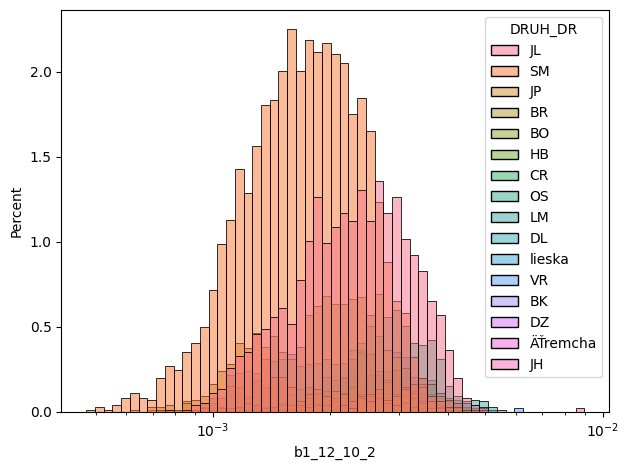

In [82]:
g = sns.histplot(data=df_sample, x='b1_12_10_2', hue='DRUH_DR', stat='percent', log_scale=True)
# g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
# g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

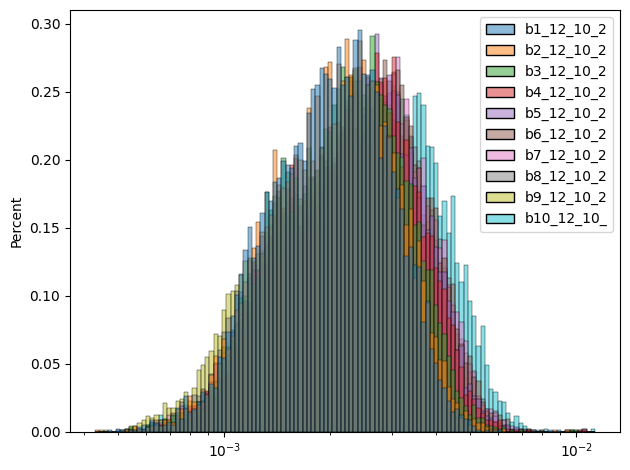

In [87]:
g = sns.histplot(df_sample[df_sample.columns[df_sample.columns.to_series().str.match(r'^b\d+.*')][0:10]], stat='percent', log_scale=True)
# g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
# g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

# Preprocess data and split it to FL sites

In [18]:
num_sites = 4

# data_dir = os.path.join('..', 'data')
# filename = os.path.join(data_dir, 'hysped_integrovane_redukovane.csv')
data_dir = os.path.join('..', 'data-sverepec_24')
filename = os.path.join(data_dir, 'sverepec_24.csv')

# data
logger.debug('loading data: %s' % filename)
df = pd.read_csv(filename)

# select columns
data_cols = df.columns[df.columns.to_series().str.match(r'b\d+(_\d+)+')]
label_col = df.DRUH_DR.name
all_cols = data_cols.append(pd.Index([label_col]))
logger.debug('selecting columns: %s' % all_cols.values)
df = df[all_cols]

# drop rows having at least 1 column na
df = df.dropna(axis=0, how='any')

# data cleaning - keep records with defined labels
df = df[~df.DRUH_DR.isna() & df.DRUH_DR.str.match(r'[A-Z]{2}|lieska')]

# # replace nan in labels
# df[label_col] = df[label_col].fillna('NaN')

# encode string labels
logger.debug('encoding labels: %s' % label_col)
label_encoder = LabelEncoder()
df[label_col] = label_encoder.fit_transform(df[label_col])

# save encoder
encoder_filename = os.path.join(data_dir, 'encoder-%s.npy' % label_col)
logger.debug('saving encoder: %s' % encoder_filename)
np.save(encoder_filename, label_encoder.classes_)
        
site_dfs = []
# randomly sample data into proportionally-sized sites and split it to train and test for each site
for i in trange(num_sites, desc='sampling site data'):

    # sample site data
    frac = 1 / (num_sites - i)
    site_df = df.sample(frac = frac)
    df = df.drop(site_df.index)

    # split site data to train and test
    site_df_train, site_df_test = split_df(site_df, split=0.7)

    site = i + 1  
    site_dir = os.path.join(data_dir, 'site-%d' % site)
    if not os.path.isdir(site_dir):
        os.mkdir(site_dir)
       
    # make symlink to label encoder
    symlink = os.path.join(site_dir, os.path.basename(encoder_filename))
    if not os.path.exists(symlink):
        os.link(encoder_filename, symlink)
    
    site_df_train.to_csv(os.path.join(site_dir, 'train.csv'), index=False)
    site_df_test.to_csv(os.path.join(site_dir, 'test.csv'), index=False)

2023-03-08 13:32:47,194 | hysped | DEBUG : loading data: ../data-sverepec_24/sverepec_24.csv
2023-03-08 13:32:47,491 | hysped | DEBUG : selecting columns: ['b1_12_10_2' 'b2_12_10_2' 'b3_12_10_2' 'b4_12_10_2' 'b5_12_10_2'
 'b6_12_10_2' 'b7_12_10_2' 'b8_12_10_2' 'b9_12_10_2' 'b10_12_10_'
 'b11_12_10_' 'b12_12_10_' 'b13_12_10_' 'b14_12_10_' 'b15_12_10_'
 'b16_12_10_' 'b17_12_10_' 'b18_12_10_' 'b19_12_10_' 'b20_12_10_'
 'b21_12_10_' 'b22_12_10_' 'b23_12_10_' 'b24_12_10_' 'b25_12_10_'
 'b26_12_10_' 'b27_12_10_' 'b28_12_10_' 'b29_12_10_' 'b30_12_10_'
 'b31_12_10_' 'b32_12_10_' 'b33_12_10_' 'b34_12_10_' 'b35_12_10_'
 'b36_12_10_' 'b37_12_10_' 'b38_12_10_' 'b39_12_10_' 'b40_12_10_'
 'b41_12_10_' 'b42_12_10_' 'b43_12_10_' 'b44_12_10_' 'b45_12_10_'
 'b46_12_10_' 'b47_12_10_' 'b48_12_10_' 'b49_12_10_' 'b50_12_10_'
 'b51_12_10_' 'b52_12_10_' 'b53_12_10_' 'b54_12_10_' 'b55_12_10_'
 'b56_12_10_' 'b57_12_10_' 'b58_12_10_' 'b59_12_10_' 'b60_12_10_'
 'b61_12_10_' 'b62_12_10_' 'b63_12_10_' 'b64_12_10_' 

sampling site data:   0%|          | 0/4 [00:00<?, ?it/s]

In [82]:
site_df_train.shape

(16848, 475)

In [83]:
data_dir = os.path.join('..', 'data')
label_encoder_filename = os.path.join(data_dir, 'encoder-DRUH_DR.npy')
np.load(label_encoder_filename, allow_pickle=True)

array(['BK', 'BO', 'BR', 'CR', 'DL', 'DZ', 'HB', 'JH', 'JL', 'JP', 'LM',
       'OS', 'SM', 'VR', 'lieska'], dtype=object)